<a href="https://colab.research.google.com/github/boomyun713/114_homework/blob/main/%E6%9C%9F%E6%9C%AB%E5%B0%88%E9%A1%8C_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance pandas_ta

In [2]:
!pip install yfinance

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
tickers = ['NVDA', 'TSLA', 'LLY', 'SMCI', 'MSFT']
start_date = '2020-01-01'
end_date = '2024-12-31'

In [5]:
data = yf.download(tickers, start=start_date, end=end_date)['Close']

/tmp/ipython-input-3057592906.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  5 of 5 completed


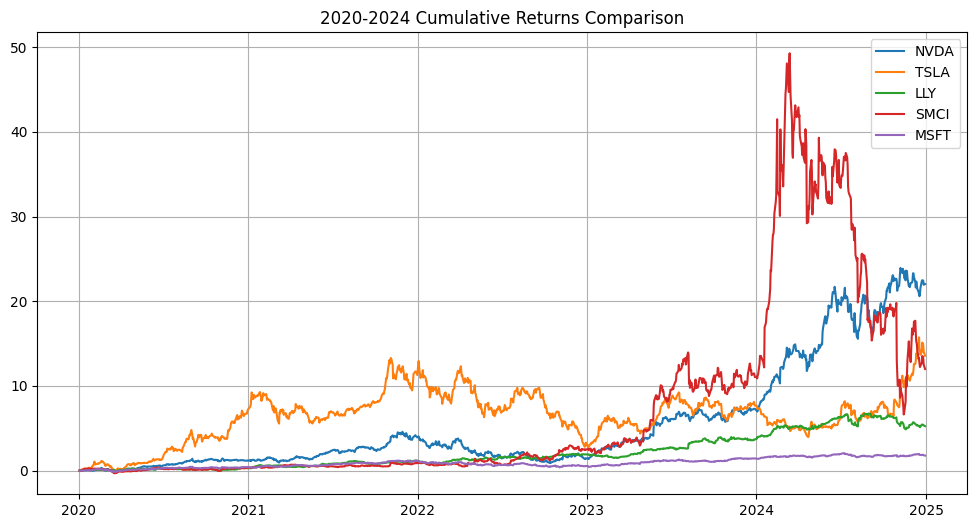

In [6]:
cumulative_returns = (1 + data.pct_change()).cumprod() - 1

plt.figure(figsize=(12, 6))
for ticker in tickers:
    plt.plot(cumulative_returns.index, cumulative_returns[ticker], label=ticker)

plt.title('2020-2024 Cumulative Returns Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
!pip install yfinance pandas_ta

In [9]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [12]:
tickers = ['NVDA', 'TSLA', 'LLY', 'SMCI', 'MSFT']
start_date = '2020-01-01'
end_date = '2025-11-30'

print(f"正在下載資料... {tickers}")
data = yf.download(tickers, start=start_date, end=end_date)['Close']

/tmp/ipython-input-2210096051.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  5 of 5 completed

正在下載資料... ['NVDA', 'TSLA', 'LLY', 'SMCI', 'MSFT']


In [13]:
def calculate_technicals(df, ticker):
    # 建立單一股票的 DataFrame
    stock_df = pd.DataFrame(df[ticker])
    stock_df.columns = ['Close']
    # 1. 移動平均線 (MA) - 判斷趨勢
    stock_df['MA50'] = stock_df['Close'].rolling(window=50).mean()
    stock_df['MA200'] = stock_df['Close'].rolling(window=200).mean()

    # 2. RSI (相對強弱指標) - 判斷過熱/過冷
    stock_df['RSI'] = ta.rsi(stock_df['Close'], length=14)

    # 3. MACD - 判斷動能
    macd = ta.macd(stock_df['Close'])
    stock_df = pd.concat([stock_df, macd], axis=1)

    # 4. 布林通道 (Bollinger Bands) - 判斷波動與壓力支撐
    bbands = ta.bbands(stock_df['Close'], length=20)
    stock_df = pd.concat([stock_df, bbands], axis=1)

    # 計算成交量變化 (需額外抓取 Volume 資料，此處簡化以價格波動率代替波動風險)
    stock_df['Volatility'] = stock_df['Close'].pct_change().rolling(window=20).std()

    return stock_df

In [14]:
def generate_llm_prompt(ticker, stock_df, validation_split_date='2024-12-31'):

    # 取得 2024 年最後一個交易日的數據
    last_row = stock_df.loc[:validation_split_date].iloc[-1]

    # 構建 Prompt
    prompt = f"""
    【角色設定】
    你是一位華爾街資深基金經理人，專精於 AI 與成長型股票的趨勢分析。

    【分析標的】
    股票代號: {ticker}
    時間點: 2024年12月31日 (基於過去數據預測2025年走勢)

    【技術面數據 (截至 2024年底)】
    1. 收盤價: ${last_row['Close']:.2f}
    2. 趨勢指標:
       - 50日均線: ${last_row['MA50']:.2f} (若收盤價 > MA50 為短期多頭)
       - 200日均線: ${last_row['MA200']:.2f} (若收盤價 > MA200 為長期多頭)
    3. 動能指標:
       - RSI (14): {last_row['RSI']:.2f} (通常 >70 為超買, <30 為超賣)
       - MACD Histogram: {last_row['MACD_12_26_9']:.2f}
    4. 波動指標:
       - 布林通道上緣: ${last_row['BBU_20_2.0']:.2f}
       - 波動率(20日): {last_row['Volatility']:.4f}

    【基本面與新聞概況 (模擬輸入)】
    (此處在實際論文中需透過 News API 填入 2024 Q4 的摘要)
    - 財報: 營收成長率高，AI 需求強勁。
    - 市場情緒: 極度樂觀，但也擔憂估值過高。

    【任務】
    請綜合以上數據，預測 {ticker} 在 2025 年的表現：
    1. 給出投資評級 (強烈買進 / 買進 / 持有 / 賣出)。
    2. 預測 2025 年走勢是「樂觀 (Bullish)」還是「悲觀 (Bearish)」。
    3. 列出 3 個主要風險提示。
    """
    return prompt

In [16]:
import pandas as pd
import numpy as np

# Redefine generate_llm_prompt within this cell for robustness
def generate_llm_prompt(ticker, stock_df, validation_split_date='2024-12-31'):

    # 取得 2024 年最後一個交易日的數據
    last_row = stock_df.loc[:validation_split_date].iloc[-1]

    # Dynamically get BBU column name or use default
    bbu_col_name = 'BBU_20_2.0'
    if bbu_col_name not in last_row.index:
        bbu_cols = [col for col in last_row.index if 'BBU' in col]
        if bbu_cols:
            bbu_col_name = bbu_cols[0]
        else:
            bbu_col_name = None

    # Get indicator values safely with .get() and handle potential NaN for formatting
    bbu_value = last_row.get(bbu_col_name) if bbu_col_name else np.nan
    bbu_formatted = f"${bbu_value:.2f}" if not pd.isna(bbu_value) else "N/A"

    macd_hist_value = last_row.get('MACD_12_26_9', np.nan)
    macd_hist_formatted = f"{macd_hist_value:.2f}" if not pd.isna(macd_hist_value) else "N/A"

    volatility_value = last_row.get('Volatility', np.nan)
    volatility_formatted = f"{volatility_value:.4f}" if not pd.isna(volatility_value) else "N/A"

    rsi_value = last_row.get('RSI', np.nan)
    rsi_formatted = f"{rsi_value:.2f}" if not pd.isna(rsi_value) else "N/A"

    ma50_value = last_row.get('MA50', np.nan)
    ma50_formatted = f"${ma50_value:.2f}" if not pd.isna(ma50_value) else "N/A"

    ma200_value = last_row.get('MA200', np.nan)
    ma200_formatted = f"${ma200_value:.2f}" if not pd.isna(ma200_value) else "N/A"

    # 構建 Prompt
    prompt = f"""
    【角色設定】
    你是一位華爾街資深基金經理人，專精於 AI 與成長型股票的趨勢分析。

    【分析標的】
    股票代號: {ticker}
    時間點: 2024年12月31日 (基於過去數據預測2025年走勢)

    【技術面數據 (截至 2024年底)】
    1. 收盤價: ${last_row['Close']:.2f}
    2. 趨勢指標:
       - 50日均線: {ma50_formatted} (若收盤價 > MA50 為短期多頭)
       - 200日均線: {ma200_formatted} (若收盤價 > MA200 為長期多頭)
    3. 動能指標:
       - RSI (14): {rsi_formatted} (通常 >70 為超買, <30 為超賣)
       - MACD Histogram: {macd_hist_formatted}
    4. 波動指標:
       - 布林通道上緣: {bbu_formatted}
       - 波動率(20日): {volatility_formatted}

    【基本面與新聞概況 (模擬輸入)】
    (此處在實際論文中需透過 News API 填入 2024 Q4 的摘要)
    - 財報: 營收成長率高，AI 需求強勁。
    - 市場情緒: 極度樂觀，但也擔憂估值過高。

    【任務】
    請綜合以上數據，預測 {ticker} 在 2025 年的表現：
    1. 給出投資評級 (強烈買進 / 買進 / 持有 / 賣出)。
    2. 預測 2025 年走勢是「樂觀 (Bullish)」還是「悲觀 (Bearish)」。
    3. 列出 3 個主要風險提示。
    """
    return prompt

results = []

print("\n===== 論文數據生成中 =====")

for ticker in tickers:
    # 1. 計算指標
    tech_df = calculate_technicals(data, ticker)

    # 2. 生成給 LLM 的 Prompt (您可以將 print 出來的文字複製給 ChatGPT/Gemini 測試)
    prompt = generate_llm_prompt(ticker, tech_df)

    # 3. 計算 2025 年 (1月-11月底) 的實際漲跌幅 (YTD Return)
    # 取 2024年底價格
    price_2024_end = tech_df.loc[:'2024-12-31'].iloc[-1]['Close']
    # 取 2025年最新價格 (11月底或最新)
    price_2025_nov = tech_df.iloc[-1]['Close']

    ytd_return = (price_2025_nov - price_2024_end) / price_2024_end * 100

    results.append({
        'Stock': ticker,
        '2024_End_Price': price_2024_end,
        '2025_Nov_Price': price_2025_nov,
        'Actual_2025_Return(%)': round(ytd_return, 2),
        'LLM_Prompt_Snippet': prompt[:150] + "..." # 只顯示前150字供預覽
    })

# 轉為表格顯示
results_df = pd.DataFrame(results)


===== 論文數據生成中 =====


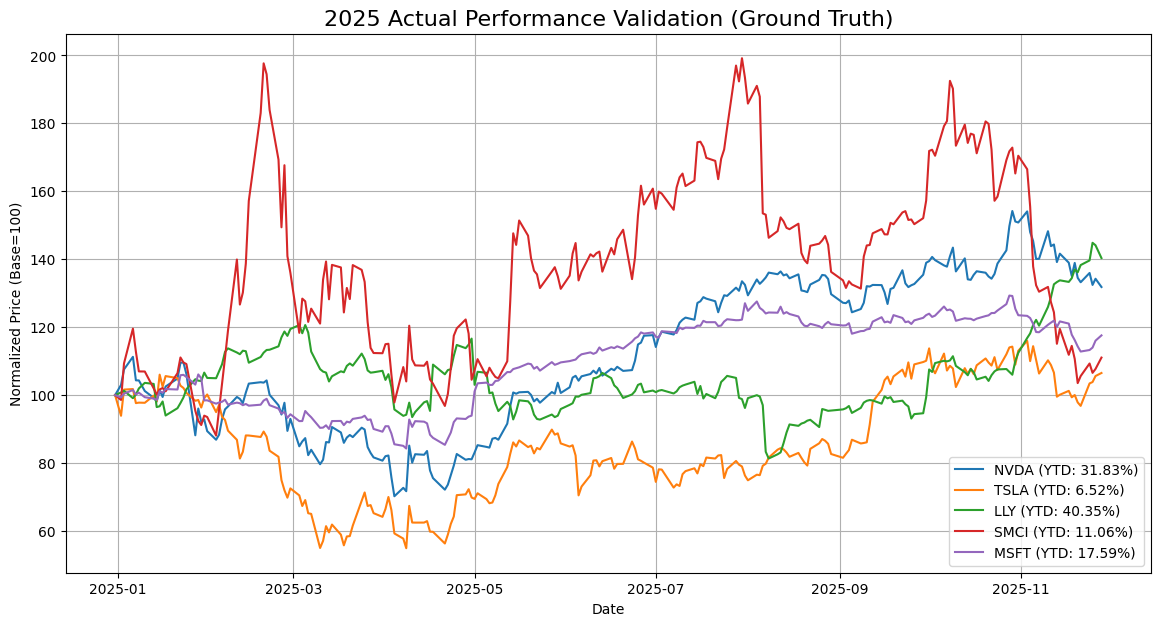


===== 分析結果表 (論文數據) =====
  Stock  Actual_2025_Return(%)
0  NVDA                  31.83
1  TSLA                   6.52
2   LLY                  40.35
3  SMCI                  11.06
4  MSFT                  17.59

===== 範例 Prompt (請複製下方文字餵給 Gemini/GPT) =====

    【角色設定】
    你是一位華爾街資深基金經理人，專精於 AI 與成長型股票的趨勢分析。

    【分析標的】
    股票代號: NVDA
    時間點: 2024年12月31日 (基於過去數據預測2025年走勢)

    【技術面數據 (截至 2024年底)】
    1. 收盤價: $134.25
    2. 趨勢指標:
       - 50日均線: $139.85 (若收盤價 > MA50 為短期多頭)
       - 200日均線: $117.82 (若收盤價 > MA200 為長期多頭)
    3. 動能指標:
       - RSI (14): 45.18 (通常 >70 為超買, <30 為超賣)
       - MACD Histogram: -0.76
    4. 波動指標:
       - 布林通道上緣: $146.33
       - 波動率(20日): 0.0215

    【基本面與新聞概況 (模擬輸入)】
    (此處在實際論文中需透過 News API 填入 2024 Q4 的摘要)
    - 財報: 營收成長率高，AI 需求強勁。
    - 市場情緒: 極度樂觀，但也擔憂估值過高。

    【任務】
    請綜合以上數據，預測 NVDA 在 2025 年的表現：
    1. 給出投資評級 (強烈買進 / 買進 / 持有 / 賣出)。
    2. 預測 2025 年走勢是「樂觀 (Bullish)」還是「悲觀 (Bearish)」。
    3. 列出 3 個主要風險提示。
    


In [17]:
data_2025 = data.loc['2024-12-31':]
normalized_data = data_2025 / data_2025.iloc[0] * 100

plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(normalized_data.index, normalized_data[ticker], label=f'{ticker} (YTD: {results_df[results_df["Stock"]==ticker]["Actual_2025_Return(%)"].values[0]}%)')

plt.title('2025 Actual Performance Validation (Ground Truth)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Normalized Price (Base=100)')
plt.legend()
plt.grid(True)
plt.show()

print("\n===== 分析結果表 (論文數據) =====")
print(results_df[['Stock', 'Actual_2025_Return(%)']])
print("\n===== 範例 Prompt (請複製下方文字餵給 Gemini/GPT) =====")
print(generate_llm_prompt(tickers[0], calculate_technicals(data, tickers[0])))